In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout

2024-04-23 19:00:25.446861: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 19:00:25.448632: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 19:00:25.479910: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 19:00:25.480938: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 19:00:25.963901: W tensorflow/compiler/tf2t

In [4]:
def resample_and_adjust_using_original_times(df, target_count):
    # Creating a new column 'Time_bin' to convert 'Time' values into 10-second bins
    df['Time_bin'] = (df['Time'] // 10 * 10).astype(int)
    
    all_time_bins = range(df['Time_bin'].min(), df['Time_bin'].max() + 10, 10)
    grouped = df.groupby('Time_bin')

    new_records = []
    last_known_price = None 
    
    # Iterating through all possible time bins
    for time_bin in all_time_bins:
        # If the current time bin exists within the grouped data
        if time_bin in grouped.groups:
            group = grouped.get_group(time_bin)
            times = group['Time'].values
            prices = group['Weighted_Price'].values
            # If the prices array is not empty, update the last known price
            if len(prices) > 0:
                last_known_price = prices[-1]
        else:
            group = None 
            
        # If the current time bin is empty or has only one price data point
        if group is None or len(prices) == 0:
            prices = np.full(target_count, last_known_price)
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
        elif len(prices) == 1:
            times = np.linspace(time_bin, time_bin + 9, num=target_count)
            prices = np.full(target_count, last_known_price)
        else:
            # If there are fewer data points than the target count, additional points will be added
            while len(prices) < target_count:
                time_diffs = np.diff(times)
                idx_to_fill = np.argmax(time_diffs)
                new_time = (times[idx_to_fill] + times[idx_to_fill + 1]) / 2
                new_price = (prices[idx_to_fill] + prices[idx_to_fill + 1]) / 2
                times = np.insert(times, idx_to_fill + 1, new_time)
                prices = np.insert(prices, idx_to_fill + 1, new_price)
            # If there are multiple data points within the time bin, proceed with normal processing
            while len(prices) > target_count:
                time_diffs = np.diff(times)
                idx_to_merge = np.argmin(time_diffs)
                new_time = (times[idx_to_merge] + times[idx_to_merge + 1]) / 2
                new_price = (prices[idx_to_merge] + prices[idx_to_merge + 1]) / 2
                times = np.delete(times, [idx_to_merge, idx_to_merge + 1])
                times = np.insert(times, idx_to_merge, new_time)
                prices = np.delete(prices, [idx_to_merge, idx_to_merge + 1])
                prices = np.insert(prices, idx_to_merge, new_price)
         # Add the processed data to the results list          
        new_records.extend(zip(times, prices))

    new_df = pd.DataFrame(new_records, columns=['Time', 'Weighted_Price'])
    new_df.sort_values('Time', inplace=True)
    return new_df

In [5]:
import os
import pandas as pd

cleaned_files_directory = 'Cleaned_Tapes'
dataframes = {}

# Loop through each cleaned CSV file and process it
for cleaned_file in os.listdir(cleaned_files_directory):
    if cleaned_file.startswith('Cleaned_') and cleaned_file.endswith('.csv'):
        # Read the cleaned file
        file_path = os.path.join(cleaned_files_directory, cleaned_file)
        df = pd.read_csv(file_path)
        
        # Extract only the 'Time' and 'Weighted_Price' columns
        subset = df[['Time', 'Weighted_Price']].copy()
        processed_df = resample_and_adjust_using_original_times(subset, 6)
        
        # Use the original file name without 'Cleaned_' as the dictionary key
        df_key = cleaned_file[len('Cleaned_'):]
        
        # Store the subset DataFrame in the dictionary
        dataframes[df_key] = processed_df
for key in dataframes:
    print(f"{key}:")
    print(dataframes[key].head())  # Show the first few rows of each DataFrame


UoB_Set01_2025-01-02tapes.csv:
      Time  Weighted_Price
0  10.8810           267.0
1  11.1445           268.0
2  12.3380           270.0
3  13.7330           267.0
4  18.3210           265.0
UoB_Set01_2025-01-03tapes.csv:
       Time  Weighted_Price
0  1.767000          281.00
1  3.758750          281.50
2  5.750500          282.00
3  6.746375          282.25
4  7.742250          282.50
UoB_Set01_2025-01-06tapes.csv:
       Time  Weighted_Price
0  3.286000      278.000000
1  4.456250      278.285714
2  5.041375      278.428571
3  5.626500      278.571429
4  6.796750      278.857143
UoB_Set01_2025-01-07tapes.csv:
   Time  Weighted_Price
0   0.0           336.0
1   1.8           336.0
2   3.6           336.0
3   5.4           336.0
4   7.2           336.0
UoB_Set01_2025-01-08tapes.csv:
   Time  Weighted_Price
0   0.0           365.0
1   1.8           365.0
2   3.6           365.0
3   5.4           365.0
4   7.2           365.0
UoB_Set01_2025-01-09tapes.csv:
      Time  Weighted_Price
0

In [6]:
def create_dataset(data, time_step, step=6):
    X, y = [], []
    for i in range(0, len(data)-time_step, step):
        X.append(data[i:(i+time_step), 0])
        y.append(data[(i+time_step):(i+time_step+6), 0])
    return np.array(X), np.array(y)

In [7]:
time_step = 360

In [8]:
training_data = []
validation_data = []

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [10]:
for index, (key, df) in enumerate(dataframes.items()):
    # Select the 'Weighted_Price' column and scale it
    price = df['Weighted_Price'].values.reshape(-1, 1)
    scaled_data = scaler.fit_transform(price)

    # Create the dataset
    X, y = create_dataset(scaled_data, time_step)

    # Reshape the data as required by your model
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = y.reshape(y.shape[0], y.shape[1], 1)

    # Split the data into training and validation sets
    if index < 80:  # First 80 DataFrames for training
        training_data.append((X, y))
    elif 80 <= index < 100:  # Next 20 DataFrames for validation
        validation_data.append((X, y))

In [11]:
X_train_combined = np.concatenate([X for X, y in training_data])
y_train_combined = np.concatenate([y for X, y in training_data])
X_valid_combined = np.concatenate([X for X, y in validation_data])
y_valid_combined = np.concatenate([y for X, y in validation_data])

In [12]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train_combined.shape[1], X_train_combined.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dense(100, activation='relu'))
model.add(Dense(units=6))  

In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
history = model.fit(
    X_train_combined, y_train_combined,
    epochs=50, batch_size=64,
    validation_data=(X_valid_combined, y_valid_combined)
)

Epoch 1/50
3750/3750 [==============================] - 639s 170ms/step - loss: 0.0088 - val_loss: 0.0142
Epoch 2/50
3750/3750 [==============================] - 662s 177ms/step - loss: 0.0088 - val_loss: 0.0142
Epoch 3/50
3750/3750 [==============================] - 670s 179ms/step - loss: 0.0088 - val_loss: 0.0142
Epoch 4/50
3750/3750 [==============================] - 671s 179ms/step - loss: 0.0088 - val_loss: 0.0142
Epoch 5/50
3750/3750 [==============================] - 672s 179ms/step - loss: 0.0088 - val_loss: 0.0142
Epoch 6/50
3750/3750 [==============================] - 641s 171ms/step - loss: 0.0088 - val_loss: 0.0142
Epoch 7/50
3750/3750 [==============================] - 595s 159ms/step - loss: 0.0088 - val_loss: 0.0143
Epoch 8/50
3750/3750 [==============================] - 636s 170ms/step - loss: 0.0088 - val_loss: 0.0142
Epoch 9/50
3552/3750 [===========================>..] - ETA: 31s - loss: 0.0088

KeyboardInterrupt: 

In [17]:
model.save('model6.keras')

In [18]:
predictions_dict = {}
true_values_dict = {}
for test_index, (key, df) in enumerate(dataframes.items()):
    if test_index >= 100:  # Skip if index is >= 100
        price = df['Weighted_Price'].values.reshape(-1, 1)
        scaled_data = scaler.fit_transform(price)
    
        # Create the dataset
        X, y = create_dataset(scaled_data, time_step)
    
        # Reshape the data as required by your model
        X = X.reshape(X.shape[0], X.shape[1], 1)
        predictions = model.predict(X)
        predictions = scaler.inverse_transform(predictions)
        predictions_dict[key] = predictions.flatten()
        true_values_dict[key] = y.flatten()

94/94 [==============================] - 3s 37ms/step


In [19]:
for key in true_values_dict.keys():
    values = np.array(true_values_dict[key]).reshape(-1, 1)
    true_values_dict[key] = scaler.inverse_transform(values).flatten()

In [24]:
from sklearn.metrics import r2_score
for key in predictions_dict:
    if key in true_values_dict:
        predictions = predictions_dict[key]
        true_values = true_values_dict[key]
        rmse = np.sqrt(mean_squared_error(true_values, predictions))
        r_squared = r2_score(true_values, predictions)
        print(key)
        print('Root Mean Squared Error:', rmse)
        print('R² Score:', r_squared)

UoB_Set01_2025-05-28tapes.csv
Root Mean Squared Error: 19.70840730869585
R² Score: -38.02817839728557
UoB_Set01_2025-05-29tapes.csv
Root Mean Squared Error: 12.821703505348362
R² Score: -14.464469782685887
UoB_Set01_2025-05-30tapes.csv
Root Mean Squared Error: 10.169729343246134
R² Score: -7.346158596295384
UoB_Set01_2025-06-02tapes.csv
Root Mean Squared Error: 5.646438614262452
R² Score: -1.7283630989233587
UoB_Set01_2025-06-03tapes.csv
Root Mean Squared Error: 5.336340790685578
R² Score: -1.1939795537608098
UoB_Set01_2025-06-04tapes.csv
Root Mean Squared Error: 6.278724016704012
R² Score: -2.1172912111720703
UoB_Set01_2025-06-05tapes.csv
Root Mean Squared Error: 6.421741672448589
R² Score: -1.2978216269294545
UoB_Set01_2025-06-06tapes.csv
Root Mean Squared Error: 7.006834973100483
R² Score: -2.1502822980607026
UoB_Set01_2025-06-09tapes.csv
Root Mean Squared Error: 7.4729492373406785
R² Score: -3.3473977288226484
UoB_Set01_2025-06-10tapes.csv
Root Mean Squared Error: 7.317604472727073

In [21]:
all_predictions = np.array([])
all_true_values = np.array([])

for key in predictions_dict:
    all_predictions = np.concatenate((all_predictions, predictions_dict[key]))
    all_true_values = np.concatenate((all_true_values, true_values_dict[key]))

rmse = np.sqrt(mean_squared_error(all_true_values, all_predictions))
r_squared = r2_score(all_true_values, all_predictions)

print('Overall Root Mean Squared Error:', rmse)
print('Overall R² Score:', r_squared)

Overall Root Mean Squared Error: 6.881539454793308
Overall R² Score: -2.457981267982807


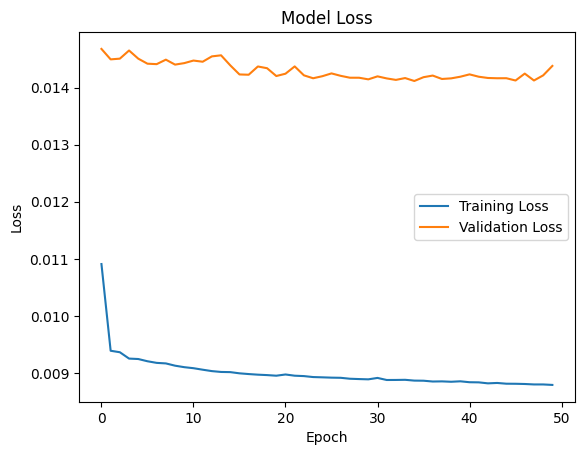

In [23]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')  # Add label for training loss plot
plt.plot(history.history['val_loss'], label='Validation Loss')  # Add label for validation loss plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # This line creates the legend based on the provided labels
plt.title('Model Loss')  # Set the title of the plot
plt.show()